In [1]:
import sqlite3
import pandas as pd
import polars as pl
pd.options.mode.chained_assignment = None

import sys
sys.path.append('../')
sys.path.append('../networks')

from functions.env import  DB_SCIENCE_PATH_NEW, GRAPH_RESULTS

conn = sqlite3.connect(DB_SCIENCE_PATH_NEW)

from functions.datamodel import OptimumParameter
from functions.feat_network import get_edge_node_table
from functions.feat_visualization import sygma_graph_leiden
from optimal_clustering import optimal_clustering

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

# compute average distance:
import pickle
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# Use the filterwarnings function to filter and suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
# Function to calculate cosine similarity between position vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)

In [2]:
import glob

list_df = []
paths = glob.glob('../networks/data/weighted/*')
for path in paths:
    df = pd.read_csv(path, index_col = [0])
    df = df[['wikidata_id', 'meta_occupation']]
    df['meta_occupation'] = df['meta_occupation'].apply(lambda x: x.split(' | '))
    df = df.explode('meta_occupation')
    df = df.reset_index(drop=True)
    df.columns = ['source', 'target']
    df['weight'] = 1
    list_df.append(df)


In [3]:
list_edge_filtered = []
list_nodes = []
for element in tqdm(list_df):
    df_net = pl.from_pandas(element)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge_filter = df_edge[
        df_edge["source"] != df_edge["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    df_edge_filter = df_edge_filter[['source', 'target', 'weight', 'specificity']].copy()
    #maxtrix = df_edge_filter.pivot(index='source', columns='target', values='weight').fillna(0)
    list_edge_filtered.append(df_edge_filter)
    list_nodes.append(df_nodes)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 64.41it/s]


In [4]:
df_edge_filtered_average = pd.concat([x for x in list_edge_filtered])
df_edge_filtered_average = df_edge_filtered_average.groupby(['source', 'target'])['weight'].sum().reset_index()
df_edge_filtered_average['weight'] = df_edge_filtered_average['weight'] / 100 # divide by the number of occupations to get the mean
df_edge_filtered_average = df_edge_filtered_average.sort_values('weight', ascending=False)
df_edge_filtered_average.to_csv('edges_list_filtered/average_edges_list.csv')


df_nodes_average = pd.concat([x for x in list_nodes])
df_nodes_average = df_nodes_average.groupby(['node'])['sum_weight'].mean().reset_index()

In [5]:
# visualization
df_partition, g = sygma_graph_leiden(
df_edge_filtered_average,
df_nodes_average,
edge_bins=10,
node_bins=10,
filepath='average_network_pre_1700.html')

In [6]:
df_partition.to_csv('average_network_partition.csv')

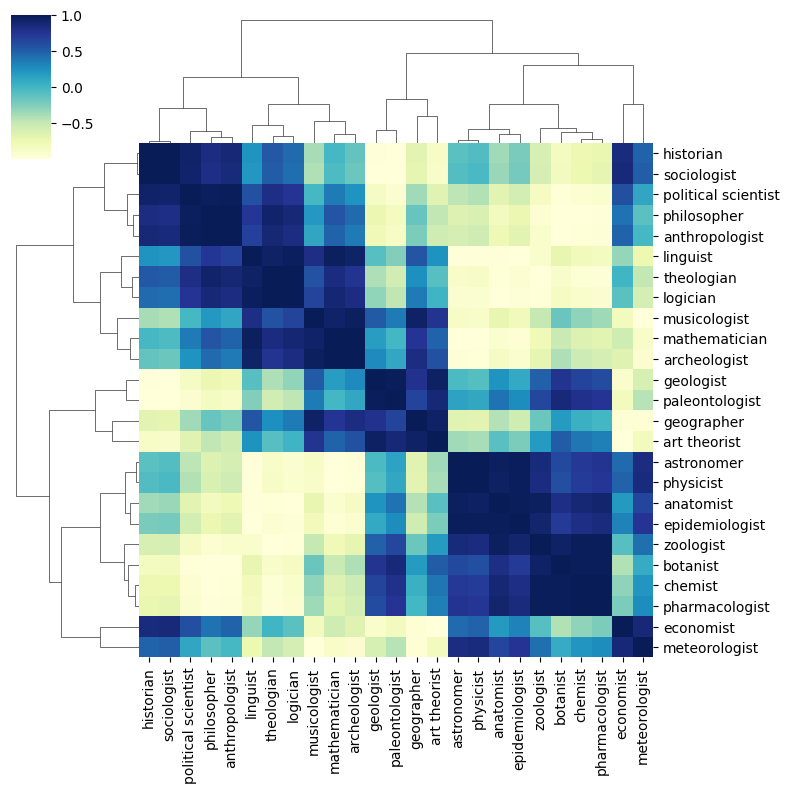

In [7]:
import networkx as nx
g = nx.from_pandas_edgelist(df_edge_filtered_average)
pos = nx.spring_layout(g, seed = 41)

occupations = list(g.nodes())
similarity_matrix = np.zeros((len(occupations), len(occupations)))

for i, occupation_i in enumerate(occupations):
    for j, occupation_j in enumerate(occupations):
        pos_i = pos[occupation_i]
        pos_j = pos[occupation_j]
        #pos_i = pos[occupation_i].reshape(1,-1)
        #pos_j = pos[occupation_j].reshape(1,-1)
        #similarity_matrix[i][j] = euclidean_distances(pos_i, pos_j)
        similarity_matrix[i][j] = cosine_similarity(pos_i, pos_j)

similarity_df = pd.DataFrame(similarity_matrix, index=occupations, columns=occupations)
sns.clustermap(similarity_df, cmap="YlGnBu", figsize=(8, 8))
plt.show()